# Fys245 Oblig 
### Johan Zapffe og Astrid Moum

grpgfsd


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Oppgave 1
Beregn transmissjonskoeffisienten til en partikkel beskrevet som en planbølge. 
Planbølgen har økende energier fra 20 eV.

Trinnpotensial med E > V0. Planbølge kommer inn fra venstre og treffer potensialtrinnet (Sett inn figur?)

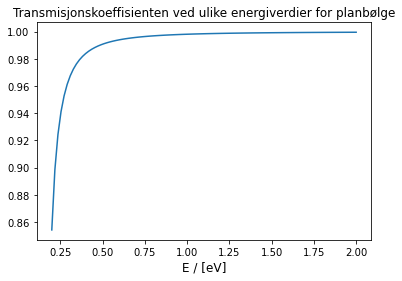

In [8]:
h_bar = 6.582 * 1e-16  # [eV*s]
m = 9.11 * 1e-31  # mass of electron [kg]

E = np.linspace(0.20, 2, 100)  # [eV]
V0 = 0.16  # [eV]

def T(E, V0):
    """
    Funksjon for å kalkulere transmissjonskoeffisienten til en partikkel beskrevet som en planbølge.
    Transmissjonskoeffisienten vil være i intervallet [0,1]. Dette beskriver prosentandelen av bølgen som
    transmitteres
    
    Inputs
    ------
    E - ndarray
        1D numpy array av energier til de innkommende planbølgene
    
    V0 - float
        Den potensielle energien til potensialtrinnet
    
    Returns
    -------
    T - ndarray
        1D numpy array av transmisjonskoeffisientene. I intervallet [0,1]
    
    """
    k = np.sqrt(2*m*E) / h_bar
    k0 = np.sqrt(2*m*(E-V0)) / h_bar
    T = (4*k*k0)/(k+k0)**2
    
    return T
    
# Lager et plot av transmissjonskoeffisienten ved ulike verdier for energi
plt.plot(E, T(E,V0))
plt.title("Transmisjonskoeffisienten ved ulike energiverdier for planbølge")
plt.xlabel("E / [eV]", fontsize=12)
plt.show()


## Oppgave 2


### Stationary states


In [9]:
def psi_n(L, x, n):
    """
    Funsjon for å finne den n'te stasjonære tilstanden til ??.
    
    Inputs
    ------
    L - 
    x -
    n - 
    
    Returns
    -------
    
    
    """
    return np.sqrt(2/L) * np.sin(n * np.pi * x / L )



### Bølgepakken

In [12]:
sigma = 1* 1e-8  # [m]
E = 0.20  # [eV]
V0 = 0.16  # [eV]

t = 0
delta_t = 2.25 * 1e-19  # [s]
delta_x = 1.5 * 1e-10  # [m]

def SL_tidsavh(x):
    """
    
    """
    phi_t = math.exp(1j*E*t/h_bar)
    return -h_bar**2 / (2*m) *2nd_d_phi() + V(x) * phi(x)*phi_t 

def V(x):
    """
    The potential energy of the particle. Will be infinite 
    
    Returns:
    --------
    float
        The potential energy of the particle   
    """
    if x < 0 or x > 200:
        return "infinite"
    if 0 < x < 100:
        return 0
    else:
        return V0
    

def d_t_phi(x, t):
    """
    Funksjon for å regne ut den tidsderiverte av den tidsavhengige Shrödingerlikningen
    
    Returns
    -------
    float
        den tidsderiverte av den tidsavhengige Shrödingerlikningen
    
    See Also
    --------
    phi(x, t)
        Den tidsavhengige bølgefunksjonen
    """
    return (phi(x, t+delta_t) - phi(x, t)) /  delta_t


def 2nd_d_x_phi(x, t):
    """
    Funksjon for å regne ut den andrederiverte av posisjon fra den tidsavhengige Shrödingerlikningen
    
    Returns
    -------
    float
        2nd posisjonsderiverte av den tidsavhengige Shrödingerlikningen
    
    See Also
    --------
    phi(x, t)
        Den tidsavhengige bølgefunksjonen
    
    """
    return (phi(x + delta_x, t) - 2 * phi(x, t)) + phi(x - delta_x, t)/  delta_x**2
    
def phi(sigma, x_0, x, t):
    """
    Den tidsavhengige bølgefunksjonen
    
    """
    return ksi(sigma, x_0) * math.exp(1j*E*t/h_bar)

def ksi(sigma, x_0, dx, k):
    """
    Den stasjonære bølgelikningen
    """
    k = np.sqrt(2*m*E) / h_bar
    x = x_0 + dx
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x_0)**2 / (2*sigma**2))) * np.exp(1j*k*(x-x_0))

SyntaxError: invalid syntax (<ipython-input-12-f9c4bbb8f46d>, line 14)